# First Zonal Harmonic Forecasting via LSTM

In this notebook, I attempt the most basic prediction for the first zonal harmonic of the external field in response to solar activity. The zonal harmonic, corresponding to the associated Legendre polynomial $P_1^0$, is effectively what is measured by the disturbance storm time (Dst) index, except the data that I am trying to reconstruct record only the external field response, while Dst inadvertently includes the fields generated in Earth's subsurface. 

In [1]:
# general
import numpy as np
from sklearn import preprocessing
import os
import datetime as dt
from helper_functions import *

# deep learning
import tensorflow as tf
from aux_keras import *

# file management, io
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

Using TensorFlow backend.


## Load Data

Let's load the data without gaps as well as the external coefficients. We'll use the unfiltered coefficients since the filtered coefficients eliminate quite a bit of small scale structure in the time series; in particular many jumps and abrupt changes in the external magnetic field are excessively smoothed and would cause the network to learn unrealistic behaviors.

In [2]:
omni = pd.read_hdf('omni_hourly_1998-2018_nogaps.h5')
coeff = pd.read_hdf('external_coefficients_unfiltered.h5')

The external coefficients report hourly values centered on every half hour, starting at 0:30 on January 1, 1999 (UT). The OMNI series, however, are centered on the hour beginning at 0:00 on January 1, 1998, but contain data averaged throughout the subsequent hour (i.e. hour 0 contains data averaged from 0:00-1:00). While the documentation for the OMNI data do not mention this anywhere, they also report the times with respect to universal time UT, so the time formats are the same between the datasets. 

Thus, both datasets contain data averaged within the same time bins, the bin centers are just denoted differently with the centers at the beginning of the hour for OMNI and at the middle of the hour for the external coefficient series. 

The OMNI data go until 23:00 December 31, 2018, and the corresponding total number of expected data points is computed below and compared to the observed total number of data points.

In [3]:
hrs_yr = 365*24
hrs_yr_lp = 366*24

n_yr = 21
# 2000, 2004, 2008, 2012, 2016
n_lp_yr = 5

hrs_OMNI = hrs_yr*(n_yr-n_lp_yr) + hrs_yr_lp*n_lp_yr

print('Expected number of hours in OMNI data set: %d' % hrs_OMNI)
print('Number of hours in OMNI data set: %d' % len(omni))

Expected number of hours in OMNI data set: 184080
Number of hours in OMNI data set: 184080


As the above code computes, the anticipated number of hours in the OMNI data set is 184080, which is precisely what we get. 

Below, we perform a similar computation for the external coefficients, which span 0:30 January 1, 1999 to 22:30 December 31, 2018. Thus, there should be exactly one year and one hour fewer data points than the OMNI set, since the external coefficients end an hour early in 2018.

In [4]:
hrs_offset = hrs_yr + 1
hrs_ext_coeff = hrs_OMNI - hrs_offset

print('Expected number of hours in external coefficients data set: %d' % hrs_ext_coeff)
print('Number of hours in external coefficients data set: %d' % len(coeff))

Expected number of hours in external coefficients data set: 175319
Number of hours in external coefficients data set: 175319


Thus, the relevant parts of OMNI are neglecting 1998 and the last entry of 2018, which I remove below.

In [5]:
omni = omni[hrs_yr:-1].reset_index(drop=True)
dst = omni['Dst-index, nT']
q10 = coeff['q10']
t = coeff['time'].values
t_year = 2000+t/(365.25) # federico's time axis

Finally, let's include previous values of the $q_1^0$ series in the input data, adding a column then to omni_lr (for now, ideally I wouldn't need to know previous values to make an accurate prediction). Let's also drop the Dst column (I revisit Dst prediction in the [sister notebook](forecasting_Dst_LSTM.ipynb) to this).

Other columns that we'll drop for the moment are:
- Kp-index
- AL-index
- AU-index
- AE-index
- ap-index

since I'm primarily interested in how explicitly physical measurements can be related to predictions of the external field.

Let's also do a simplest case forecasting, using only the following columns (at the moment):
- $B_z$
- SW proton density
- SW plasma speed
- SW plasma temperature

In [6]:
omni = omni.drop(columns=['Dst-index, nT', 'Kp-index', 'AE-index, nT', 'AL-index, nT', 'AU-index, nT', 'ap-index, nT'])

#omni = omni[['BZ, nT (GSM)', 'SW Plasma Temperature, K', 'SW Plasma Speed, km/s', 'SW Proton Density, N/cm^3']]
omni['q10'] = q10.values

input_dim = len(omni.columns)
output_dim = 1
ndat = len(omni)

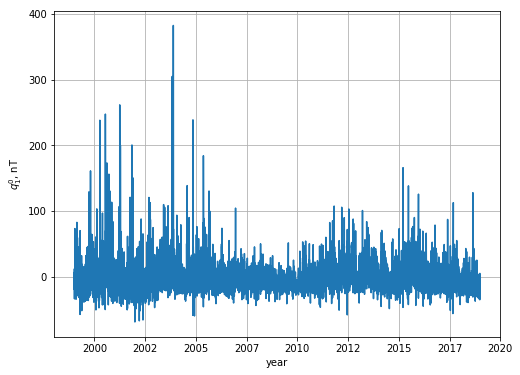

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_year, q10)
ax.set_ylabel('$q_1^0$, nT')
ax.set_xlabel('year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.grid(True)
plt.show()

## Compare q10 with Dst

Here is a scatter plot of the first zonal coefficient $q_1^0$ compared to Dst, demonstrating their similarities. 

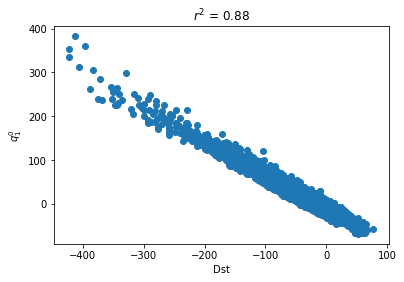

In [28]:
r2 = np.corrcoef(dst,q10)[0,1]**2

plt.figure()
plt.scatter(dst,q10)
plt.ylabel('$q_1^0$')
plt.xlabel('Dst')
plt.title('$r^2$ = %1.2f' % r2)
plt.show()

The sign convention differs between datasets, but they both record quite similar values, except during the largest storms when $q_1^0$ takes on larger values than Dst.

## LSTM with Keras

Having imported the data, let's design, train, and test the LSTM network for this prediction problem. The LSTM specifics are in the [aux_keras.py](aux_keras.py) module, where two basic architectures are elaborated. One is stateless, in which batches of fixed length are fed to the LSTM during training, while another is stateful, with the entire unbroken training series fed into the LSTM, thereby capturing the entire time history of the training data. 

### Split and Prepare Data

Let's separate the data into training and testing sets. Let's also normalize all of the data according to the training data.

In [ ]:
batch_size = 500
lahead = 6
train_percent = 0.8

In [ ]:
# split
data_in_train, data_out_train, data_in_test, data_out_test = datasplit(omni.values, \
                        q10.values.reshape(-1,1), batch_size, train_percent, lahead, stateful=True)

# normalize
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train = scaler_input.fit_transform(data_in_train)
data_in_test = scaler_input.transform(data_in_test)

scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
data_out_train = scaler_output.fit_transform(data_out_train)
data_out_test = scaler_output.transform(data_out_test)

# reshape input data
data_in_train = data_in_train.reshape(-1, 1, input_dim)
data_in_test = data_in_test.reshape(-1, 1, input_dim)

In [ ]:
rnn, hist = train_network(data_in_train, data_out_train, batch_size, epochs=100, stateful=True)
plt.plot(hist)

### Test

In [ ]:
data_out_pred = test_network(data_in_test, data_out_test, rnn, batch_size,'$\epsilon_1^0$', scaler_output)

## LSTM with Torch

Now, let's practice with Torch and develop a similar LSTM network for q10 forecasting.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

It would be good to practice with the torch Dataset and Dataloader classes, which I'll do at some future point.

In [30]:
# form dataset and dataloader classes here...

Below I specify a model class following the tutorials at https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html and http://www.jessicayung.com/lstms-for-time-series-in-pytorch/.

In [31]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=1):
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # we'll also need an output layer (equivalent of dense in keras)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda(),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())

    # number of input data must be divisible by batch_size
    def forward(self, input):
        self.hidden = self.init_hidden()
        lstm_out, self.hidden = self.lstm(input.view(-1, self.batch_size, self.input_dim), self.hidden)
        train_pred = self.linear(lstm_out)
        return train_pred

Make input data into torch tensors with cuda support for running on the gpu.

In [ ]:
# make training data into cuda tensors
data_in_train = torch.from_numpy(data_in_train).float().cuda()
data_out_train = torch.from_numpy(data_out_train).float().cuda()

# make testing data into cuda tensors
data_in_test = torch.from_numpy(data_in_test).float().cuda()
data_out_test = torch.from_numpy(data_out_test).float().cuda()

Train here

In [ ]:
hidden_dim = 20
batch_size = 500
num_layers = 1

model = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_layers)

# run on gpu
model.cuda()

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

nepochs = 20000
hist = np.zeros(nepochs)

for epoch in range(nepochs):
    optimizer.zero_grad()
    model.hidden = model.init_hidden()
    train_pred = model(data_in_train)
    loss = loss_function(train_pred, data_out_train.view(-1, batch_size, output_dim))
    
    hist[epoch] = loss.item()
    
    if epoch % 100 == 0:
        print('Epoch %d, MSE: %1.2e' % (epoch, loss.item()))
    
    loss.backward()
    optimizer.step()

plt.figure()
plt.plot(hist)
plt.show()

In [ ]:
model.hidden = model.init_hidden()
test_pred = model(data_in_test)
test_pred = test_pred.reshape(-1,1)

x = data_out_test.cpu().detach().numpy()
y = test_pred.cpu().detach().numpy()
plotcorr(x, y)

In [ ]:
plt.figure()
plt.plot(x, '.-')
plt.plot(y, '.--')
plt.show()

## Storm-time Prediction

Let's repeat the above, but isolate training to storm times. We'll define geomagnetic storms as periods with more than 50 nT deviation (positively for $q_1^0$) from the baseline, which identifies the main phases of the storms. Given that the main phases are preceded by an initial phase of slightly increasing terrestrial external field (which for $q_1^0$ is a slight decrease), I'll include the 24 hours prior to the peak storm time. Furthermore, given that storms themselves can last for several days, I'll include the following 168 hours of data, which should in almost all cases cover the recovery phase. Since 168+24 is approximately 200, I'll just consider batches of 200 hours that encapsulate the geomagnetic storm.

In [8]:
# first, threshold all q10 values
main_idx = q10 > 60

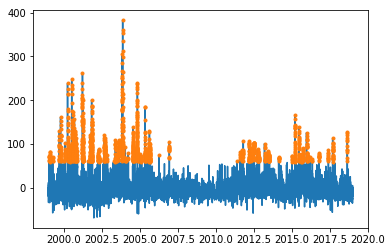

In [9]:
plt.figure()
plt.plot(t_year, q10)
plt.plot(t_year[main_idx], q10[main_idx], '.')
plt.show()

I need to be careful about detecting multiples storms in close proximity, however, since these are likely to be the same storm, and so we should not double count it in the data set. 

In [17]:
nhr_after = 100
nhr_before = 36

storm_idx = findstorm(q10, 60, less=False, nhr_before=nhr_before, nhr_after=nhr_after)

batch_size = nhr_before + nhr_after

Having identified storms, now split up the storms into training and testing sets.

In [175]:
# don't forget to modify the indices to reflect the time shift!
lahead = 6
train_percent = 0.8

rnd_ord = np.random.permutation(nstorm)

ntrain = int(train_percent*nstorm)
ntest = nstorm - ntrain

train_idx = storm_idx[rnd_ord[0:ntrain]]
test_idx = storm_idx[rnd_ord[ntrain:]]

In [176]:
data_in_train = np.zeros((ntrain, batch_size, input_dim))
data_out_train = np.zeros((ntrain, batch_size))

for ii in range(ntrain):
    data_in_train[ii, :, :] = omni.loc[train_idx[ii,0]-lahead:train_idx[ii,1]-lahead-1].values
    data_out_train[ii, :] = q10[train_idx[ii,0]:train_idx[ii,1]]
    
data_in_test = np.zeros((ntest, batch_size, input_dim))
data_out_test = np.zeros((ntest, batch_size))

for ii in range(ntest):
    data_in_test[ii, :, :] = omni.loc[test_idx[ii,0]-lahead:test_idx[ii,1]-lahead-1].values
    data_out_test[ii, :] = q10[test_idx[ii,0]:test_idx[ii,1]]

In [177]:
# normalize
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train = scaler_input.fit_transform(data_in_train.reshape(-1, input_dim)).reshape(-1, batch_size, input_dim)
data_in_test = scaler_input.transform(data_in_test.reshape(-1, input_dim)).reshape(-1, batch_size, input_dim)

scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
data_out_train = scaler_output.fit_transform(data_out_train.reshape(-1, 1)).reshape(-1, batch_size)
data_out_test = scaler_output.transform(data_out_test.reshape(-1, 1)).reshape(-1, batch_size)

Now prepare data for pytorch LSTM network, train, and test.

In [178]:
# make training data into cuda tensors
data_in_train = torch.from_numpy(data_in_train).float().cuda()
data_out_train = torch.from_numpy(data_out_train).float().cuda()

# make testing data into cuda tensors
data_in_test = torch.from_numpy(data_in_test).float().cuda()
data_out_test = torch.from_numpy(data_out_test).float().cuda()

Epoch 0, MSE: 6.93e-03
Epoch 100, MSE: 4.20e-03
Epoch 200, MSE: 2.79e-03
Epoch 300, MSE: 2.30e-03
Epoch 400, MSE: 2.08e-03
Epoch 500, MSE: 1.92e-03
Epoch 600, MSE: 1.80e-03
Epoch 700, MSE: 1.71e-03
Epoch 800, MSE: 1.65e-03
Epoch 900, MSE: 1.60e-03
Epoch 1000, MSE: 1.54e-03
Epoch 1100, MSE: 1.48e-03
Epoch 1200, MSE: 1.40e-03
Epoch 1300, MSE: 1.33e-03
Epoch 1400, MSE: 1.39e-03
Epoch 1500, MSE: 1.72e-03
Epoch 1600, MSE: 1.67e-03
Epoch 1700, MSE: 1.65e-03
Epoch 1800, MSE: 1.64e-03
Epoch 1900, MSE: 1.63e-03
Epoch 2000, MSE: 1.62e-03
Epoch 2100, MSE: 1.61e-03
Epoch 2200, MSE: 1.61e-03
Epoch 2300, MSE: 1.60e-03
Epoch 2400, MSE: 1.59e-03
Epoch 2500, MSE: 1.59e-03
Epoch 2600, MSE: 1.58e-03
Epoch 2700, MSE: 1.57e-03
Epoch 2800, MSE: 1.55e-03
Epoch 2900, MSE: 1.30e-03
Epoch 3000, MSE: 1.27e-03
Epoch 3100, MSE: 1.26e-03
Epoch 3200, MSE: 1.25e-03
Epoch 3300, MSE: 1.24e-03
Epoch 3400, MSE: 1.24e-03
Epoch 3500, MSE: 1.23e-03
Epoch 3600, MSE: 1.23e-03
Epoch 3700, MSE: 1.22e-03
Epoch 3800, MSE: 1.21e-0

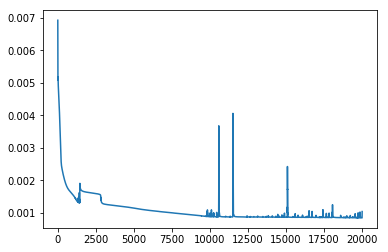

In [179]:
hidden_dim = 4
num_layers = 1

model = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_layers)

# run on gpu
model.cuda()

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

nepochs = 20000
hist = np.zeros(nepochs)

for epoch in range(nepochs):
    optimizer.zero_grad()
    model.hidden = model.init_hidden()
    train_pred = model(data_in_train)
    loss = loss_function(train_pred, data_out_train.view(-1, batch_size, output_dim))
    
    hist[epoch] = loss.item()
    
    if epoch % 100 == 0:
        print('Epoch %d, MSE: %1.2e' % (epoch, loss.item()))
    
    loss.backward()
    optimizer.step()

plt.figure()
plt.plot(hist)
plt.show()

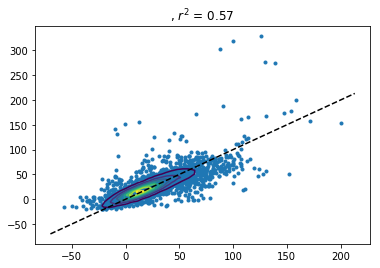

In [180]:
model.hidden = model.init_hidden()
test_pred = model(data_in_test)
test_pred = test_pred.reshape(-1, batch_size)

x = data_out_test.cpu().detach().numpy()
y = test_pred.cpu().detach().numpy()

x = scaler_output.inverse_transform(x)
y = scaler_output.inverse_transform(y)

plotcorr(x, y)